# Clustering with Phenograph

## Table of Contents
- Importing
- Pre-Processing
- Clustering with PhenoGraph

PhenoGraph is a graph-based clustering algorithm to identify sub-populations of cells in high-dimensional single-cell data in an unsupervised manner. The algorithm represents the underlying cellular population by a graph (or network) in which each cell is connected to other cells that are phenotypically similar. This graph is then clustered into distinct phenotypic communities, using modularity optimization. While it can be used for any sample size, PhenoGraph is especially powerful for large samples (thousands or hundreds of thousands of cells), where it is produces high-quality results without downsampling.

See [our manuscript](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4508757/) for more details.

Here, we demonstrate how to use Phenograph to cluster sub-populations of cells from the dataset *3k PBMCs from a Healthy Donor*, which is freely available from 10x Genomics (at this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)) and also downloaded for this tutorial.

## Importing

In the steps below, we use the Scanpy package to process and illustrate transformations to our dataset. This requires us to convert our 10X data to an AnnData object, which is compatible with Scanpy.

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
from matplotlib import pyplot as plt
import phenograph
import copy
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
%matplotlib inline

In [2]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.1 scipy==1.4.1 pandas==1.1.2 scikit-learn==0.23.2 statsmodels==0.12.0 python-igraph==0.8.2 leidenalg==0.8.1


In [3]:
#Directory where the 10X MEX-format gene-barcode matrices are stored
path_to_10xdata = "data/filtered_gene_bc_matrices/hg19/"

adata = sc.read_10x_mtx(path = path_to_10xdata,
                        var_names = "gene_symbols",
                        cache = True)
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
sc.pp.calculate_qc_metrics(adata, inplace = True)
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

## Pre-Processing

Some basic pre-processing and analysis is required before using PhenoGraph. Below, we perform gene- and cell- filtering, library-size normalization, and log-scale transformation. If using your own dataset, you should perform any pre-processing before using PhenoGraph.</b>

### Count Matrix Filtering
We will first remove all genes which are not expressed in any cell, as well as low library size cells:

In [4]:
# Filter all genes with no expression in any cells
adata_filtered_genes = sc.pp.filter_genes(adata, min_cells=10, copy = True)
#Filter all cells with library size < 100
adata_filtered = sc.pp.filter_cells(adata_filtered_genes, min_genes=100, copy = True)

/Users/peerlabloaner2/miniconda3/envs/scrna-default/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/Users/peerlabloaner2/miniconda3/envs/scrna-default/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


### Library Size Normalization
Next, we normalize the library size of our cells (the summed rows of our counts matrix) to the median library size:

In [5]:
#Find median library size for our dataset and normalize
med_libsize = np.median(np.sum(adata_filtered.X.toarray(), axis = 1))
print("Median library size is " + str(med_libsize))
adata_norm = sc.pp.normalize_per_cell(adata_filtered, counts_per_cell_after = med_libsize, copy = True)

Median library size is 2193.5


/Users/peerlabloaner2/miniconda3/envs/scrna-default/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


### Removal of Mitochondrial and Ribosomal Protein Genes
Although optional, we can also find and remove mitochondrial and ribosonal protein genes altogether from our dataset. We perform this step after library size normalization, so that we do not over-enrich genes in cells with high mitochondrial or ribosomal RNA content:

In [6]:
#Identify mitochondrial genes
mito_genes = adata.var_names.str.startswith('MT-').tolist()
#Identify ribosomal protein genes using a pre-compiled list
with open('RB_genes_human.txt') as f:
    ribo_genes = [s.strip("\n") for s in f.readlines()]
#Remove mitochondrial genes and ribosomal protein genes
adata_no_mito_RB = adata_norm[:, [gene not in mito_genes + ribo_genes for gene in adata_norm.var.index]].copy()

/Users/peerlabloaner2/miniconda3/envs/scrna-default/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


### Log-Transformation
Finally, we have chosen to transform our counts matrix to log-scale values using Scanpy's utility and default settings (log base $e$ and a pseudocount value of $1$). However, this is optional and will depend on the context of your dataset and analysis.

In [7]:
#Log-transform our dataset using the default Scanpy utility
adata_log1p = sc.pp.log1p(adata_no_mito_RB, copy = True)

### Principal Component Analysis (PCA)

Phenograph clustering is often performed after transformation according to Principal Component Analysis (PCA) of the data. PCA reduces the dimensionality of the original dataset while retaining most relevant, biological signal. For this, we typically use the first $n$ principal components that cumulatively explain a sufficient percentage of variance present in the data:

In [8]:
adata = adata_log1p
adata = sc.tl.pca(adata, n_comps = 100, copy = True)

(2700, 10972)


We can now take a look at the cumulative fraction of variance that is 'explained' by our principal components, in order. This plot is useful for deciding how many PCs we will ultimately include in our PhenoGraph clustering. In the following analyses, we will consider the first $n$ PCs which explain $20\%$ of the variance in our dataset.

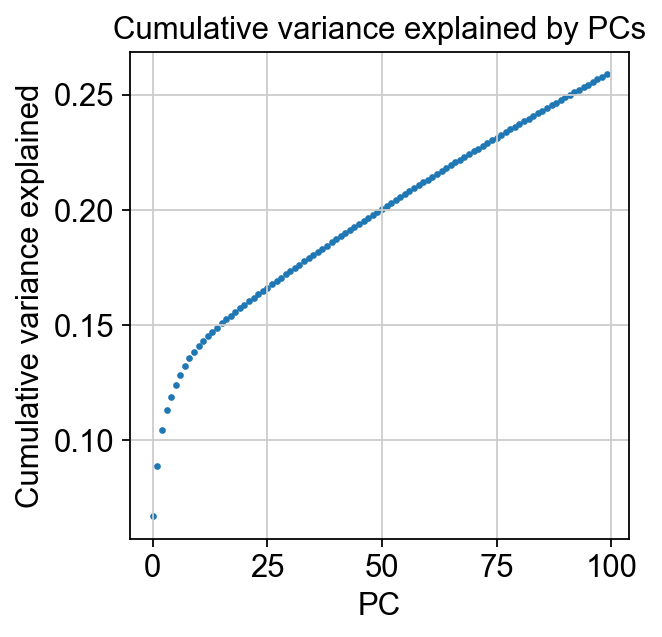

In [9]:
# Cumulative variance explained:
cml_var_explained = np.cumsum(adata.uns['pca']['variance_ratio'])
x = range(len(adata.uns['pca']['variance_ratio']))
y = cml_var_explained
plt.scatter(x, y, s=4)
plt.xlabel('PC')
plt.ylabel('Cumulative variance explained')
plt.title('Cumulative variance explained by PCs')
plt.show()

In [10]:
# set the minimum cumulative fraction of variance explained
min_cml_frac = 0.20
# find the number of PCs that together explain the minimal cum. fraction of variance
n_pcs = next(idx for idx,cml_frac in enumerate(cml_var_explained) if cml_frac > min_cml_frac)
print('Number of PCs that together explain a fraction of ' + str(min_cml_frac) + ' of the variance: ' + str(n_pcs))

Number of PCs that together explain a fraction of 0.2 of the variance: 50


For now, we will proceed with the number of principal components found above. However, we recommend you ensure your clustering results from PhenoGraph are robust to this value, i.e. they do not fluctuate significantly with small changes in your choice in the number of PCs. For example, you might compare clustering results when using 20, 30, 40, 50, 60 or 70 PCs, while holding other parameters constant. </b>

## Clustering with Phenograph

### Running Phenograph

The PhenoGraph algorithm comprises two major steps. First, an affinity matrix is constructed between all cells; by default, this is calculated from a k-nearest neighbor graph and applying the Jaccard similarity coefficient to all edge values. In the second step, this affinity matrix is used as an input to the [Louvain algorithm](https://arxiv.org/abs/0803.0476) for community detection in order to determine cell clusters. The Louvain algorithm tries to optimize the ratio of intra-cluster modularity score to inter-cluster modularity score, $Q$. This value is returned by PhenoGraph after completion along with the community assignments and a sparse representation of the graph used for clustering.

PhenoGraph clustering can be run using `phenograph.cluster()`. Additionally, PhenoGraph is integrated into Scanpy and can be run from its external tools with the function `scanpy.external.tl.phenograph()` (documentation [here](https://scanpy.readthedocs.io/en/stable/external/scanpy.external.tl.phenograph.html)). In the example below, we cluster the cells in `adata` according to their position in principal component space, first using default parameter settings and $k=30$. We also store the results, as well as our chosen $k$, in `adata`:

In [11]:
k = 30 # choose k
sc.settings.verbose = 0
communities, graph, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']),k=k) # run PhenoGraph
# store the results in adata:
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.19109869003295898 seconds
Jaccard graph constructed in 1.6498181819915771 seconds
Wrote graph to binary file in 0.36409592628479004 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.760013
Louvain completed 21 runs in 1.0242490768432617 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 3.873077630996704 seconds


To visualize the clustering results, you can apply any method for embedding data in a lower-dimensional space. Below, we use UMAP, which typically better preserves global connectivity compared to, for instance, tSNE. However, either could potentially be used.

In [12]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=n_pcs)
sc.tl.umap(adata)

/Users/peerlabloaner2/miniconda3/envs/scrna-default/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


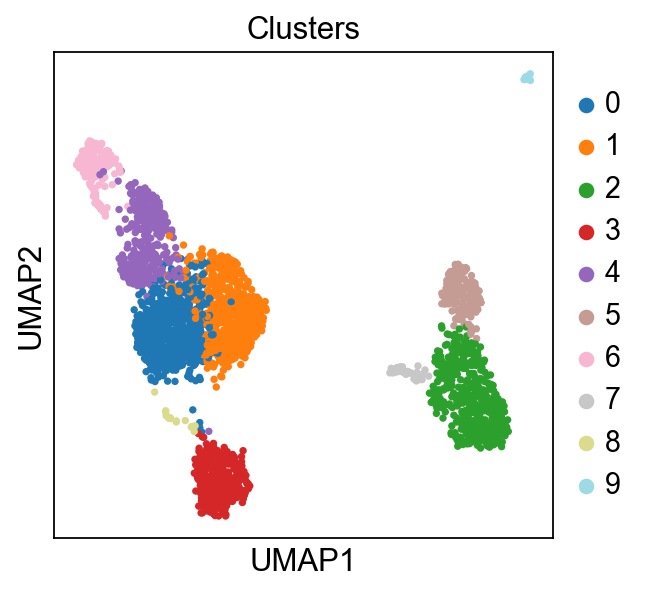

In [13]:
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["Clusters"]
)

### Choice of Parameters

PhenoGraph takes one parameter $k$ as an input to construct its k-nearest neighbor graph. In general, smaller $k$ values will produce more clusters, splitting a dataset with higher resolution, but at the risk of "over-clustering" -  erroneously partitioning clusters based on differences which aren't biologically meaningful. In contrast, higher values of $k$ will lead to a lower-resolution clustering which is more robust to the specific choice of $k$, but may lump together biologically distinct sub-clusters and sacrifice information. Below, we show different cluster assignments for increasing values of $k$:

Finding 25 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.18035197257995605 seconds
Jaccard graph constructed in 1.5293068885803223 seconds
Wrote graph to binary file in 0.24147605895996094 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.763078
Louvain completed 21 runs in 0.8896288871765137 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 3.4918317794799805 seconds
Finding 50 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.1620957851409912 seconds
Jaccard graph constructed in 1.727329969406128 seconds
Wrote graph to binary file in 0.5586507320404053 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.743169
Louvain completed 21 runs in 1.1915581226348877 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 4.331125020980835 seconds
Finding 75 nearest neighbors using minkowski metri

/Users/peerlabloaner2/miniconda3/envs/scrna-default/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


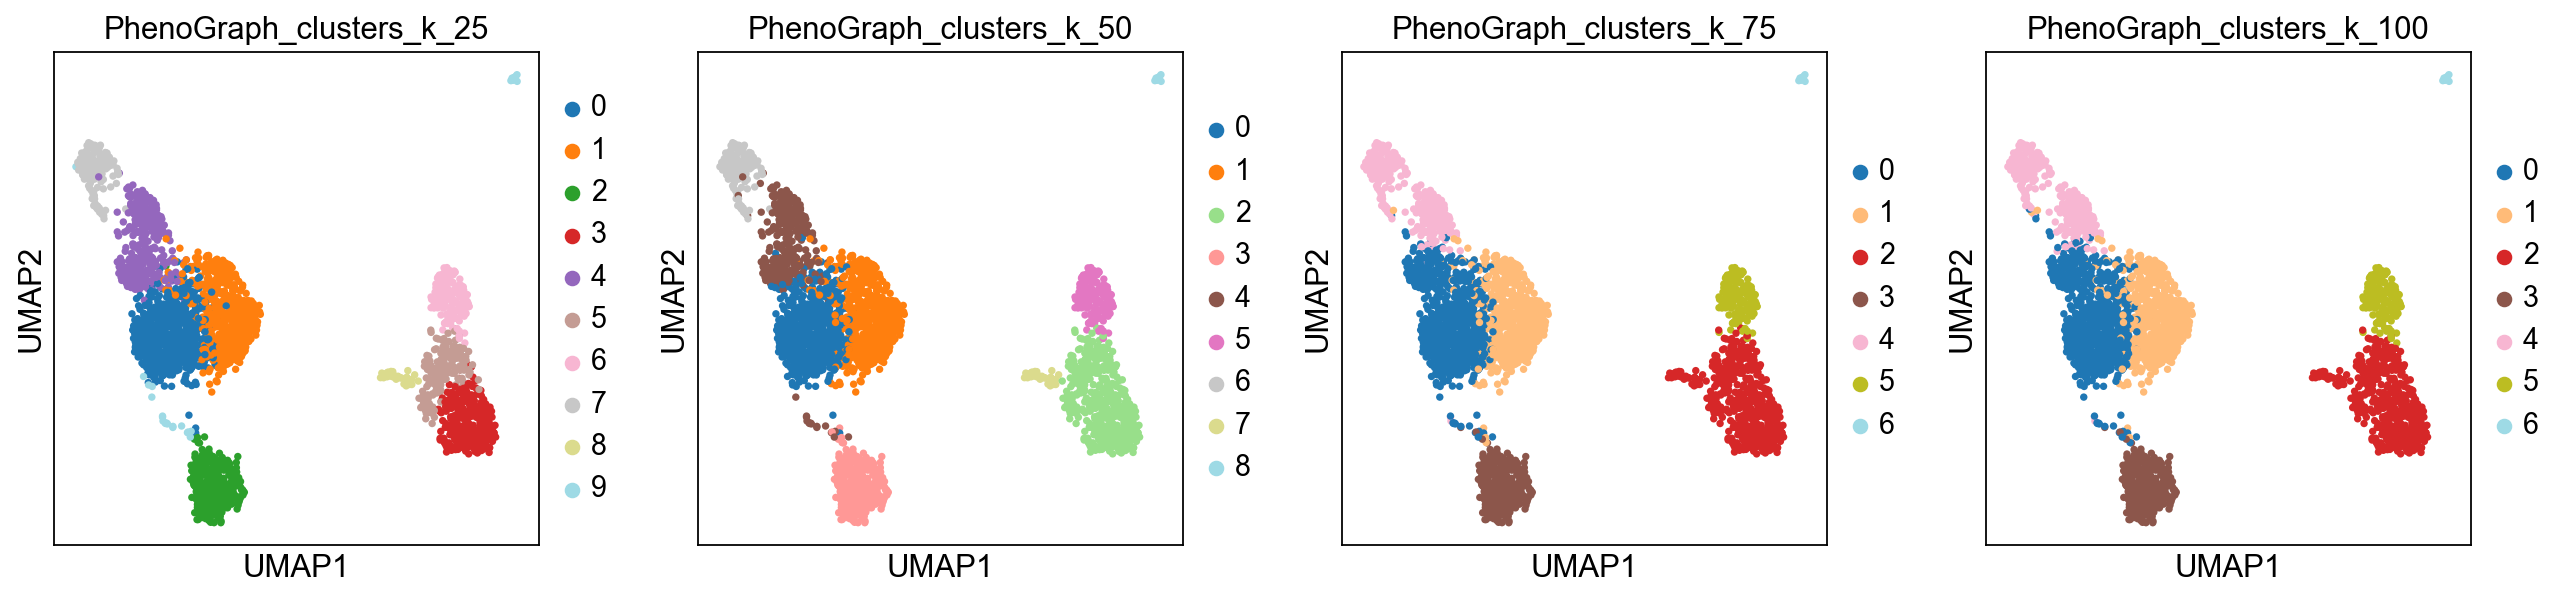

In [14]:
k_vals = np.arange(25, 101, 25)

for k in k_vals:
    communities, _, Q = phenograph.cluster(pd.DataFrame(adata.obsm['X_pca']), k=k)
    adata.obs['PhenoGraph_clusters_k_' + str(k)] = pd.Categorical(communities)
    adata.uns['PhenoGraph_Q_'+str(k)] = Q
    adata.uns['PhenoGraph_k_'+str(k)] = k
    
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters_k_' + str(k) for k in k_vals],
    palette='tab20' # 'palette' specifies the colormap to use)
)

<b> The optimal value of $k$ will ultimately depend on your dataset and type of analysis. </b> If your objective for clustering is to identify specific, small sub-populations, rather than creating a globally useful partitioning of cells, it is reasonable to limit the size of $k$. Alternatively, if your goal is to find an optimally robust cell grouping, you should choose a $k$ value that does not dramatically change cluster assignments as $k$ varies.

In general, it is a good practice to ensure your clustering result is robust to the choice of $k$ within a reasonable window of $k$ values. For example, if you use $k = 30$ to identify sub-populations of cells, then it is desirable to show that the clustering result is maintained for $k = 20, 40, 50, 60$. One can quantitatively show similarity between clustering results for various values of $k$ using metrics such as Rand Index, Normalized Mutual Information or the F-Score.

We will first define a function `calc_clustering_characteristics` which will run PhenoGraph and collect the $k$ value as well as the cluster assignments, Q score and the number of components (explained below) associated with a given value of $k$, and run function for many values of $k$:

In [15]:
# define a function that will give us the relevant output for the input k
def calc_cluster_characteristics(k, PCA):
    results = pd.Series(dtype = 'float64')
    results['k'] = k
    results['communities'], results['graph'], results['Q'] = phenograph.cluster(PCA, k=k)
    results['components'], _ = sparse.csgraph.connected_components(results['graph'], directed = False)
    return results

ks = np.arange(10, 101, 5)  # This is the range of k values we will look at
cluster_chars_list = [calc_cluster_characteristics(k, adata.obsm['X_pca']) for k in ks]
cluster_characteristics = pd.concat(cluster_chars_list, axis = 1).transpose()

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.16805791854858398 seconds
Jaccard graph constructed in 1.4281532764434814 seconds
Wrote graph to binary file in 0.05555987358093262 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.780946
After 3 runs, maximum modularity is Q = 0.783025
After 7 runs, maximum modularity is Q = 0.786136
After 19 runs, maximum modularity is Q = 0.787616
Louvain completed 39 runs in 1.6178691387176514 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 4.012293815612793 seconds
Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.18791508674621582 seconds
Jaccard graph constructed in 1.4081158638000488 seconds
Wrote graph to binary file in 0.19440007209777832 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.774855
After 15 runs, maximum modularity is Q = 0.776003


After 1 runs, maximum modularity is Q = 0.727379
Louvain completed 21 runs in 1.4820959568023682 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 6.291794776916504 seconds
Finding 95 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.1763908863067627 seconds
Jaccard graph constructed in 3.4173879623413086 seconds
Wrote graph to binary file in 0.9966058731079102 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.726911
Louvain completed 21 runs in 1.5832359790802002 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 6.842905044555664 seconds
Finding 100 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.17748188972473145 seconds
Jaccard graph constructed in 3.544172763824463 seconds
Wrote graph to binary file in 1.0838310718536377 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.725894
Lo

Below, we plot the changes in various metrics for different $k$ values. 

On the left, we show the number of 'components' (i.e. the disconnected subgraphs) for each value of $k$; a $k$ value should be selected that has only one component, and therefore no disconnected subgraphs. For example, for our dataset, a $k$ value should be selected greater than ~15.

On the right, the Q-modularity score (see PhenoGraph paper) is shown for each $k$. This value is generally used as a measure of the success of the community detection algorithm. As $k$ is increased from 0, it typically drops immediately and then only slightly decreases after a certain point. However, in the case of homogeneous data with little structure, you may see a constant rapid decay in Q score. The plot below is not needed to select a good $k$ value, but is informative about the modularity of your data.

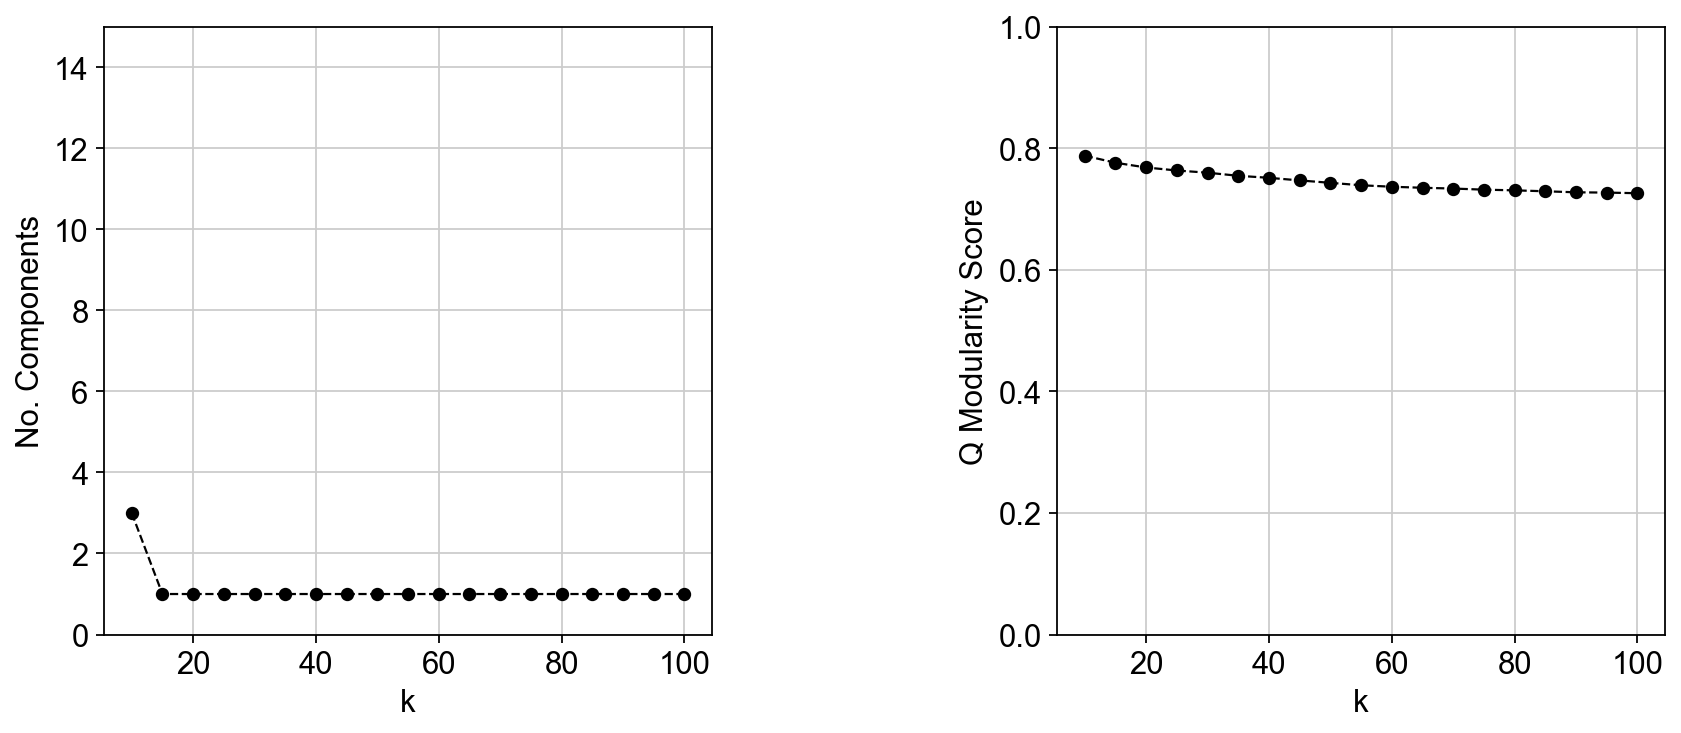

In [16]:
k = cluster_characteristics['k']
no_components = cluster_characteristics['components']
Q = cluster_characteristics['Q']

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(14, 5))
ax1.set_box_aspect(1)
ax1.plot(k, no_components, color='k', marker='o', linestyle='dashed', linewidth=1, markersize=5, )
ax1.set_xlabel('k')
ax1.set_ylabel('No. Components')
ax1.set_ylim(0, 15)

ax2.set_box_aspect(1)
ax2.plot(k, Q, color='k', marker='o', linestyle='dashed', linewidth=1, markersize=5)
ax2.set_xlabel('k')
ax2.set_ylabel('Q Modularity Score')
ax2.set_ylim(0, 1)

plt.show()
plt.close()

To quantify the similarity in cluster assignments between different $k$ values in order to select a robust $k$, we will use the Rand index. This method compares two clusterings by testing, for every pair of cells, whether they were placed in the same or different clusters. For example, if two cells were assigned to different clusters in Clustering 1, but were clustered together in Clustering 2, this will decrease their Rand index. Alternatively, if they were clustered separately or together in both Clusterings 1 and 2, their Rand index score will increase. The Rand index ranges from 0.0 to 1.0, with 1.0 indicating identical cluster assignments.

An example plot is shown below depicting the Rand index measured for all pairs of clustering results for the values of $k$ computed above:

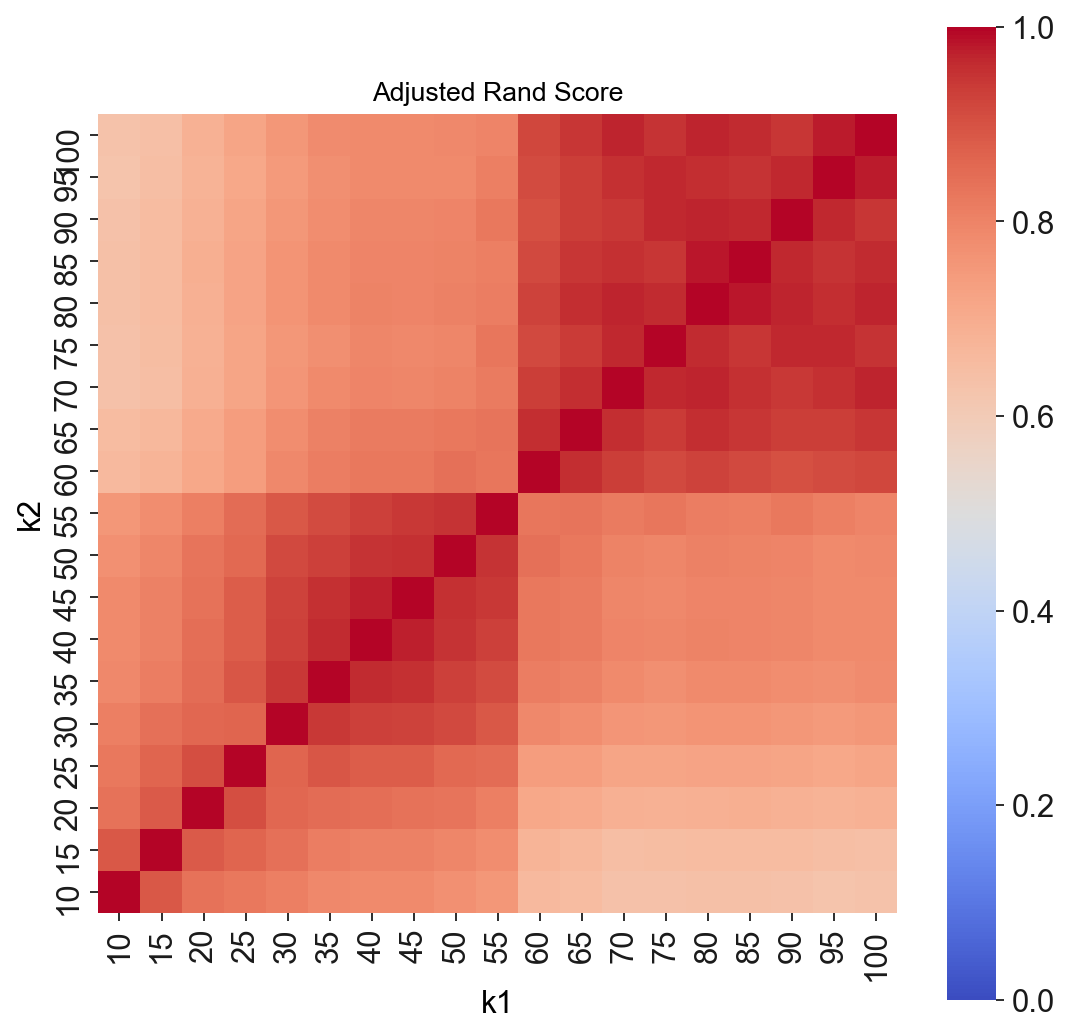

In [17]:
n = len(ks)
Rand_indices = pd.DataFrame(np.zeros((n,n)), index = ks, columns = ks)

Rand_indices.index.name = 'k1'
Rand_indices.columns.name = 'k2'

for i in range(n):
    for j in range(n):
        Rand_indices.iloc[i, j] = adjusted_rand_score(
            cluster_characteristics['communities'][i], 
            cluster_characteristics['communities'][j]
        )
        
plt.figure(figsize = (8,8))
sns.heatmap(Rand_indices, cmap=('coolwarm'), square=True, vmin=0, vmax=1).invert_yaxis()
sns.set(font_scale=1)
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score')
plt.show()
plt.close()

We can use this heatmap to find a region in which the clustering is fairly similar between different values of $k$ - in practice, we typically look for a Rand Index > 0.8 to represent a relatively "robust" clustering region. Within that 'robust region', you should choose the lowest $k$ value, to retain as much resolution as possible. Here, we choose $k = 30$ from the relatively stable region wherein $k$ ranges from $30$ to $55$.

**Additional Note**: Because Phenograph relies on heuristic optimization algorithms to perform clustering, clustering assignments between runs of the algorithm may differ. In general, for very modular datasets with clear sub-populations, different function calls with unchanged parameters will have only a small effect. However, in less-structured data (for instance, containing homogenous cells) or data describing cells which lie on a continuum, changes between runs of the Phenograph algorithm will be more significant. To illustrate this point, below, we show different cluster assignments for several runs of Phenograph, with unchanged parameter settings. 

In [18]:
k = 30 # k to use
n_runs = 4 # number of times to run PhenoGraph with unchanged parameters

cluster_cols = []

for i in range(n_runs):
    communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata.obsm['X_pca']),k=k)
    cluster_name = 'PhenoGraph_k_' + str(k) + '_run_' + str(i)
    adata.obs[cluster_name] = pd.Categorical(communities)
    cluster_cols.append(cluster_name)

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.17417693138122559 seconds
Jaccard graph constructed in 1.6582372188568115 seconds
Wrote graph to binary file in 0.3054819107055664 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.759579
Louvain completed 21 runs in 1.0795669555664062 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 3.951742172241211 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.17489314079284668 seconds
Jaccard graph constructed in 1.542180061340332 seconds
Wrote graph to binary file in 0.37993693351745605 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.759486
Louvain completed 21 runs in 0.96016526222229 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 3.726069927215576 seconds
Finding 30 nearest neighbors using minkowski metric 

/Users/peerlabloaner2/miniconda3/envs/scrna-default/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


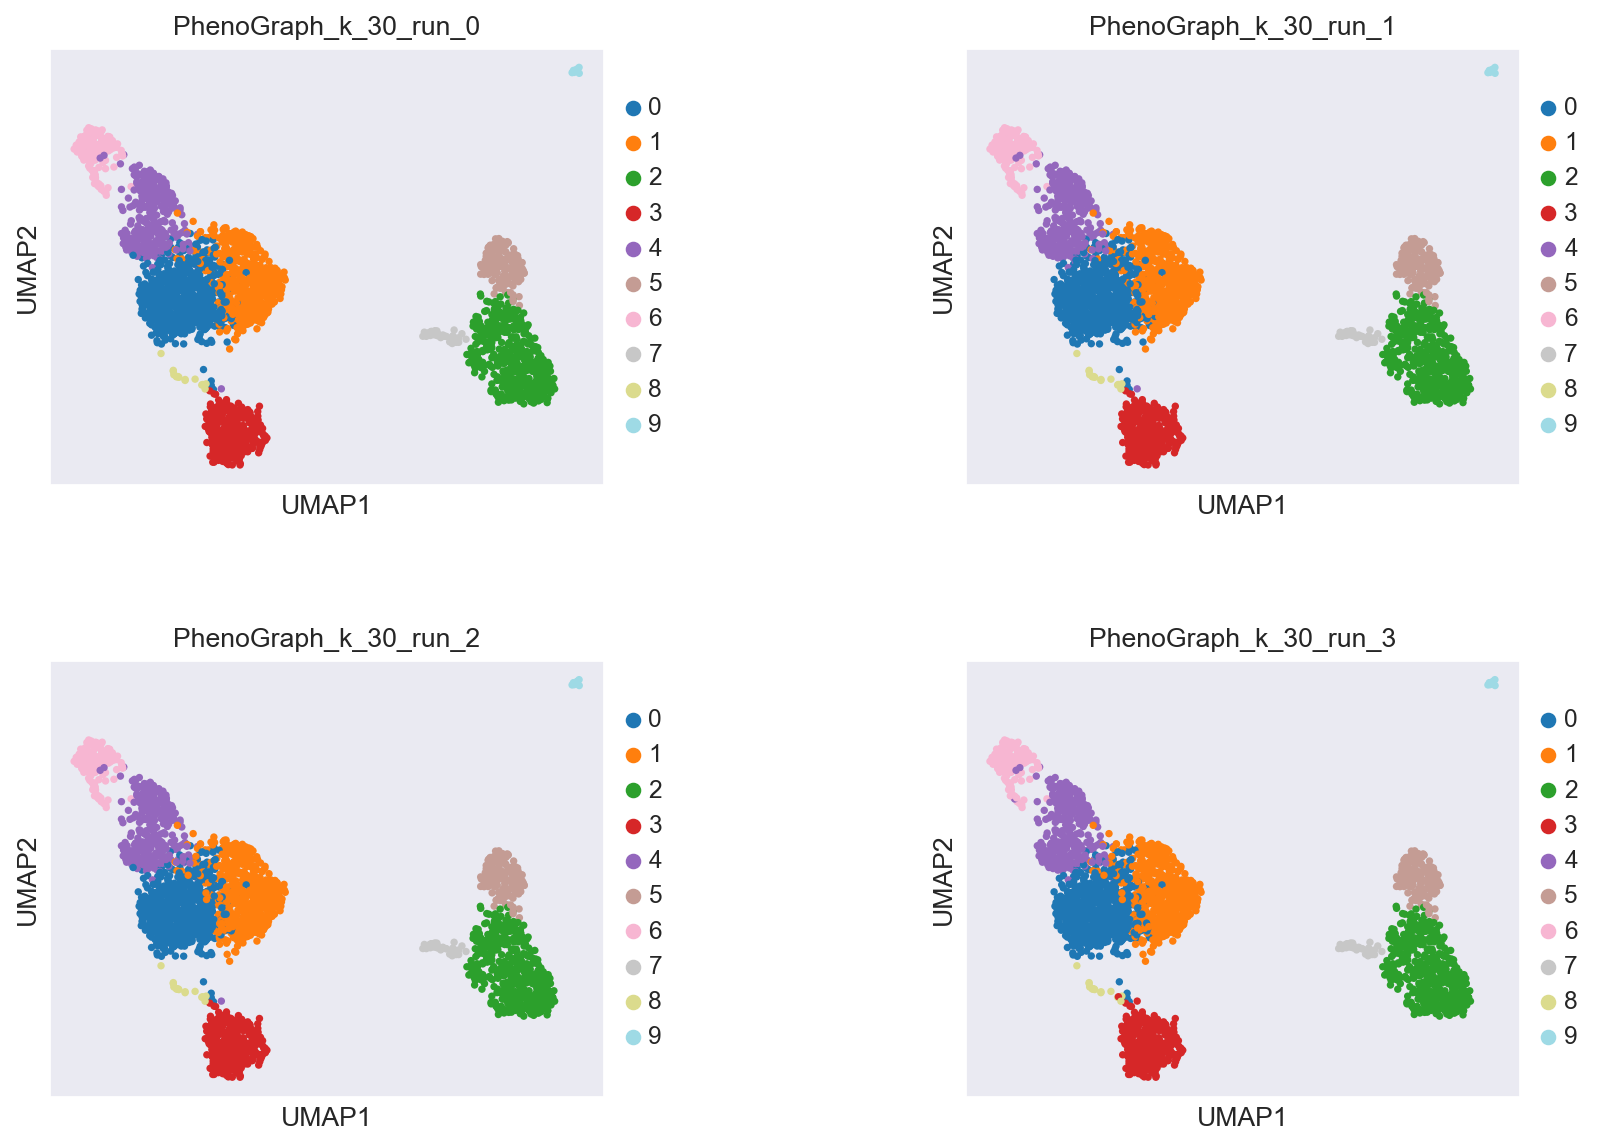

In [19]:
sc.pl.umap(
    adata,
    color=cluster_cols,
    palette='tab20',
    ncols = 2,
    wspace=.5, hspace=0.4
)

Because our dataset is relatively modular, clustering assignments between various runs should show little variation. By inspection, we can see the clustering assignments remain virtually the same between runs. However, to be more precise, we can also quantify their similarity using the Rand index method from above. You should observe high Rand index scores (Adjusted Rand Score > 0.90) for each pair.

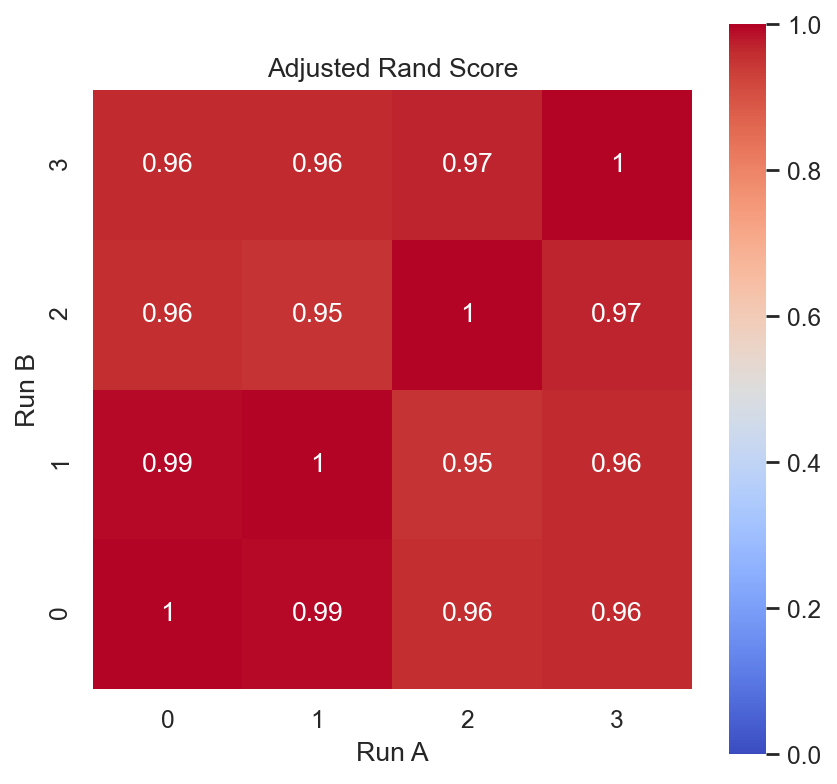

In [20]:
Rand_indices_unchanged_params = pd.DataFrame(np.zeros((n_runs,n_runs)))

for i in range(n_runs):
    for j in range(n_runs):
        Rand_indices_unchanged_params.iloc[i, j] = adjusted_rand_score(
            adata.obs[cluster_cols[i]], 
            adata.obs[cluster_cols[j]]
        )
        
plt.figure(figsize = (6,6))
sns.heatmap(Rand_indices_unchanged_params, cmap=('coolwarm'), square=True, vmin=0, vmax=1, annot = True).invert_yaxis()
sns.set(font_scale=1)
plt.xlabel('Run A')
plt.ylabel('Run B')
plt.title('Adjusted Rand Score')
plt.show()
plt.close()

## Cell Typing with Phenograph

*TODO: Add link to public Cell Typing notebook*

/Users/peerlabloaner2/miniconda3/envs/scrna-default/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


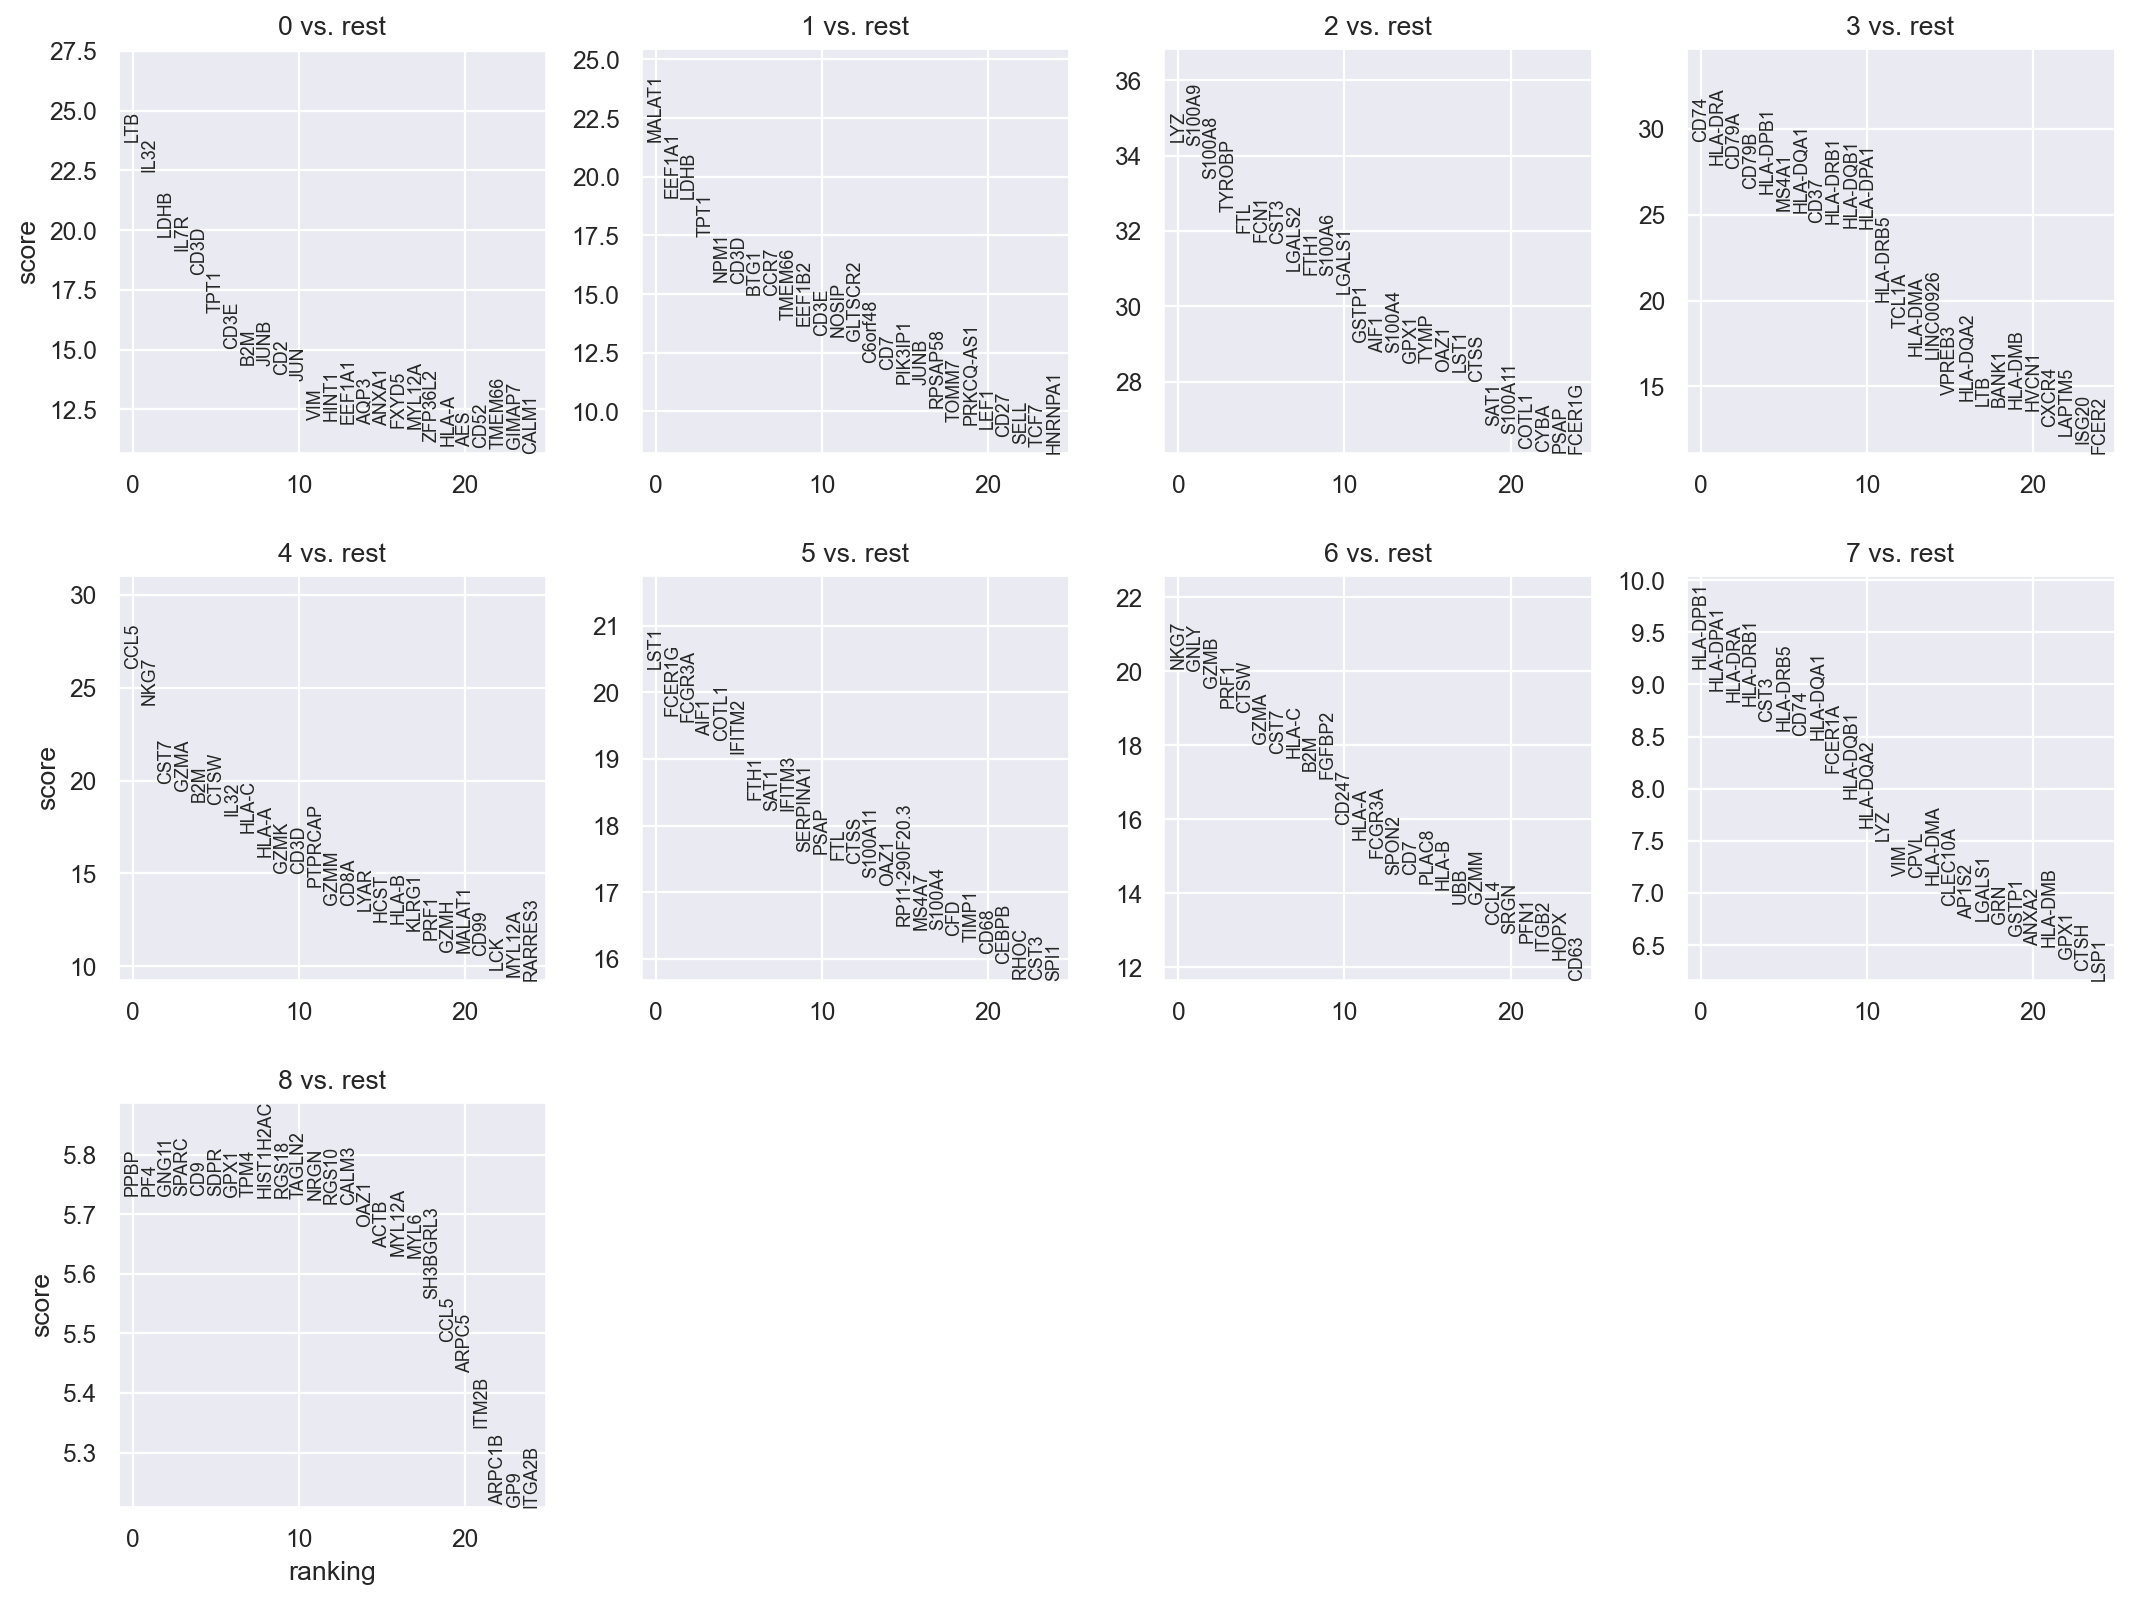

In [21]:
sc.tl.rank_genes_groups(adata, groupby = "PhenoGraph_clusters_k_50", method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [22]:
cell_markers = ["IL7R", "CD14", "MS4A1", "CD8A", "GNLY", "MS4A7", "FCER1A", "PPBP", "FOXP3"]
cell_types = ["CD4 T Cells", "CD14+ Monocytes", "B Cells", "CD8 T Cells", "NK Cells", "FCGR3A+ Monocytes", "Dendritic Cells", "Megakaryocytes", "Monocytes"]

#cell_markers = ['PTPRC', 'CD3E', 'CD3D', 'CD3G', 'CD4', 'CD8A', 'FOXP3', 'ITGAM', 'CD14', 'ITGAX', 'S100A8', 'LY75', 'BATF3', 'CD79A', 'TNFRSF17']
#cell_types = ['All Clusters', 'T Cells', 'T Cells', 'T Cells', 'CD4+ T Cells', 'CD8+ T Cells', 'FOXP3+ CD4+ T Cells', 'Leukocytes', 'CD14+ Monocytes', 'Dendritic Cells', 'Neutrophil', 'Dendritic Cells', 'Dendritic Cells', 'B Cells', 'Plasma']

#'ADGRE1', 'H2-AA', 'H2-AB1', 'LY6G', 
#'Macrophage', 'Dendritic Cells', 'Dendritic Cells', 'Neutrophils'